In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
paris = pd.read_csv("../Data/full_paris_emolex_modified.csv")
gnd = pd.read_csv("../Data/full_gnd_emolex_modified.csv")

In [3]:
emotions = ["positive", "negative", "anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]

#### Basic Comparison

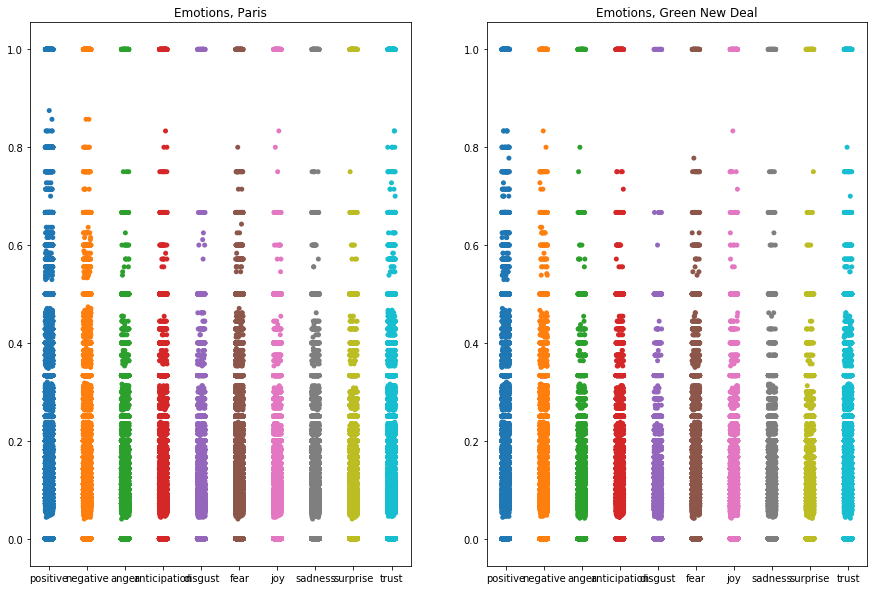

In [4]:
fig,ax = plt.subplots(1,2, figsize = (15,10))
sns.stripplot(data = paris[emotions], ax = ax[0])
ax[0].set_title("Emotions, Paris")
sns.stripplot(data = gnd[emotions], ax = ax[1])
ax[1].set_title("Emotions, Green New Deal")
plt.show()

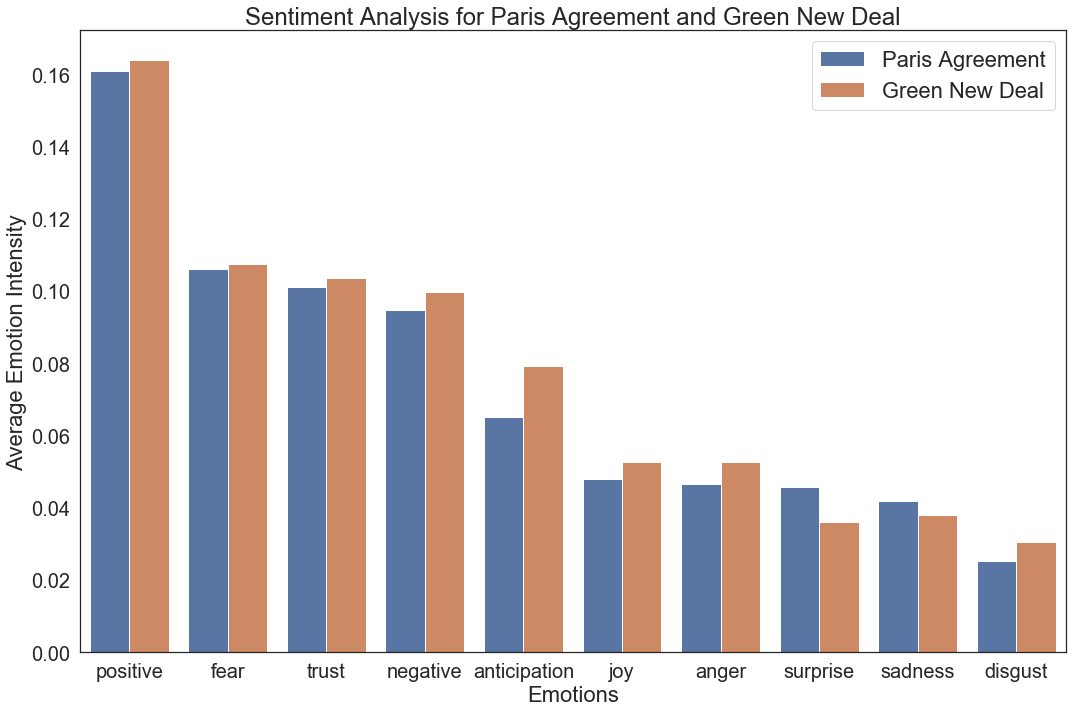

In [69]:
sns.set_style("white")
sns.color_palette("husl", 9)

fig,ax = plt.subplots(figsize = (15,10))
paris_emotions = paris[emotions].mean(axis = 0, skipna = True).rename_axis("emotions").reset_index(name="avg_emotion").sort_values(by = "avg_emotion")[::-1]
gnd_emotions = gnd[emotions].mean(axis = 0, skipna = True).rename_axis("emotions").reset_index(name="avg_emotion").sort_values(by = "avg_emotion")[::-1]
paris_emotions["Policy"] = "Paris Agreement"
gnd_emotions["Policy"] = "Green New Deal"
df_all = pd.concat([paris_emotions, gnd_emotions], axis = 0)
sns.barplot(x="emotions", y="avg_emotion", hue = "Policy",data=df_all, ax = ax) 
ax.set_ylabel("Average Emotion Intensity", fontsize = 22)
ax.set_xlabel("Emotions", fontsize = 22)
ax.set_title("Sentiment Analysis for Paris Agreement and Green New Deal", fontsize = 24)
plt.legend(fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)
plt.tight_layout()
plt.show()

#### Is there a difference in emotion toward the Green New Deal and Paris Agreement?

In [6]:
import pingouin

In [7]:
ttests_emotions = []
for emotion in emotions:
    df = pingouin.ttest(paris[emotion], gnd[emotion])
    df["emotion"] = emotion
    ttests_emotions.append(df)
ttests_emotions = pd.concat(ttests_emotions).set_index("emotion")
display(ttests_emotions)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
emotion,,,,,,,,
positive,-2.409255,47231.974674,two-sided,1.598894e-02,"[-0.01, -0.0]",0.017818,0.147,0.700498
negative,-5.151612,48686.232274,two-sided,2.592623e-07,"[-0.01, -0.0]",0.037533,4664.93,0.999474
anger,-8.588796,45885.855353,two-sided,9.059937e-18,"[-0.01, -0.0]",0.064464,8.259e+13,1.000000
anticipation,-15.243093,44068.618748,two-sided,2.489595e-52,"[-0.02, -0.01]",0.116880,1.955e+48,1.000000
disgust,-9.738134,47112.123120,two-sided,2.176648e-22,"[-0.01, -0.0]",0.072114,3.062e+18,1.000000
fear,-1.612398,49686.405634,two-sided,1.068816e-01,"[-0.0, 0.0]",0.011633,0.03,0.368186
joy,-6.304944,44619.934497,two-sided,2.909885e-10,"[-0.01, -0.0]",0.048023,3.44e+06,1.000000
sadness,6.211009,51977.010146,two-sided,5.304286e-10,"[0.0, 0.01]",0.043873,1.911e+06,1.000000
surprise,14.664996,52037.594976,two-sided,1.350980e-48,"[0.01, 0.01]",0.103535,3.518e+44,1.000000


It appears that the difference in average sentiment intensity between the green new deal and paris agreement is significant for each emotion. However, the magnitude of the these differences don't appear particularly large, at least visually, numerically...

In [8]:
df_all = paris_emotions.merge(gnd_emotions, on = "emotions", suffixes = ("_paris", "_gnd")).set_index("emotions")
df_all["difference"] = abs(df_all["avg_emotion_paris"] - df_all["avg_emotion_gnd"])
display(df_all[["difference"]])

,difference
emotions,
positive,0.003077
fear,0.001478
trust,0.002510
negative,0.005171
anticipation,0.013895
joy,0.004758
anger,0.006199
surprise,0.009486
sadness,0.003916


Although the differences between the emotions appear to be significant, their magnitude is not large. This suggests that the overall sentiment toward these initiatives is similar.

#### What about a difference between retweets and likes?

In [9]:
paris[["retweet_count", "favorite_count"]] = paris[["retweet_count", "favorite_count"]].fillna(value = 0)
gnd[["retweet_count", "favorite_count"]] = gnd[["retweet_count", "favorite_count"]].fillna(value = 0)

In [10]:
retweets_df = pingouin.ttest(paris["retweet_count"], gnd["retweet_count"])
retweets_df["Popularity Measurement"] = "Retweets"
retweets_df["paris_avg"] = paris["retweet_count"].mean()
retweets_df["gnd_avg"] = gnd["retweet_count"].mean()
likes_df = pingouin.ttest(paris["favorite_count"], gnd["favorite_count"])
likes_df["paris_avg"] = paris["favorite_count"].mean()
likes_df["gnd_avg"] = gnd["favorite_count"].mean()
likes_df["Popularity Measurement"] = "Likes"

ttests_pop = pd.concat([retweets_df, likes_df]).set_index("Popularity Measurement")
display(ttests_pop)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power,paris_avg,gnd_avg
Popularity Measurement,,,,,,,,,,
Retweets,-2.947801,30822.272242,two-sided,0.003203,"[-9.46, -1.9]",0.029110,0.623,0.982182,4.539475,10.222809
Likes,-4.084252,31487.657367,two-sided,0.000044,"[-32.62, -11.46]",0.039535,33.815,0.999811,10.068385,32.109279


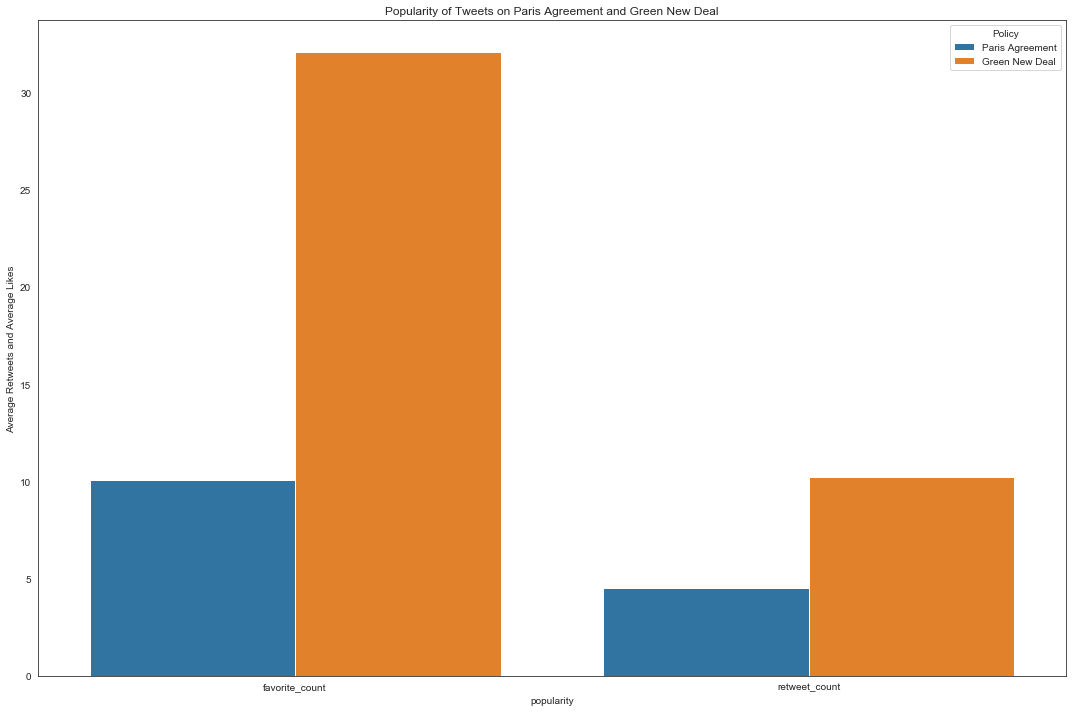

In [11]:
fig,ax = plt.subplots(figsize = (15,10))
paris_emotions = paris[["retweet_count", "favorite_count"]].mean(axis = 0, skipna = True).rename_axis("popularity").reset_index(name="average popularity").sort_values(by = "average popularity")[::-1]
gnd_emotions = gnd[["retweet_count", "favorite_count"]].mean(axis = 0, skipna = True).rename_axis("popularity").reset_index(name="average popularity").sort_values(by = "average popularity")[::-1]
paris_emotions["Policy"] = "Paris Agreement"
gnd_emotions["Policy"] = "Green New Deal"
df_all = pd.concat([paris_emotions, gnd_emotions], axis = 0)
sns.barplot(x="popularity", y="average popularity", hue = "Policy",data=df_all, ax = ax)
ax.set_ylabel("Average Retweets and Average Likes")
ax.set_title("Popularity of Tweets on Paris Agreement and Green New Deal")
plt.tight_layout()
plt.show()

However, there does seem to be a significant difference in popularity, with a fairly large difference in magnitude. Some of this may have to do with a users of people with very few followers/low engagement tweeting more often. We did not extract the information necessary to confirm this, however, it's definitely something to keep in mind.

#### Emotional Profiles of most popular and least popular tweets

In [12]:
paris_short = paris[paris["favorite_count"] <= 250]
paris_short = gnd[gnd["favorite_count"] <= 250]

In [13]:
paris.describe()

,id_str,retweet_count,favorite_count,user_id,negative,positive,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
count,6.786600e+04,67866.000000,67866.000000,6.786600e+04,67866.000000,67866.000000,67866.000000,67866.000000,67866.000000,67866.000000,67866.000000,67866.000000,67866.000000,67866.000000
mean,1.025927e+18,4.539475,10.068385,1.985871e+17,0.094679,0.160895,0.046589,0.065236,0.025333,0.106026,0.047967,0.041884,0.045645,0.101030
std,5.171472e+16,122.886597,372.363521,3.679289e+17,0.136237,0.168870,0.093000,0.112969,0.071079,0.126503,0.094671,0.090112,0.092540,0.130156
min,9.282486e+17,0.000000,0.000000,2.240000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.952587e+17,0.000000,0.000000,1.432987e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.032243e+18,0.000000,0.000000,7.244290e+08,0.000000,0.142857,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.076923
75%,1.069820e+18,1.000000,2.000000,4.035856e+09,0.166667,0.250000,0.083333,0.111111,0.000000,0.166667,0.083333,0.062500,0.083333,0.166667
max,1.128864e+18,21083.000000,66525.000000,1.128445e+18,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


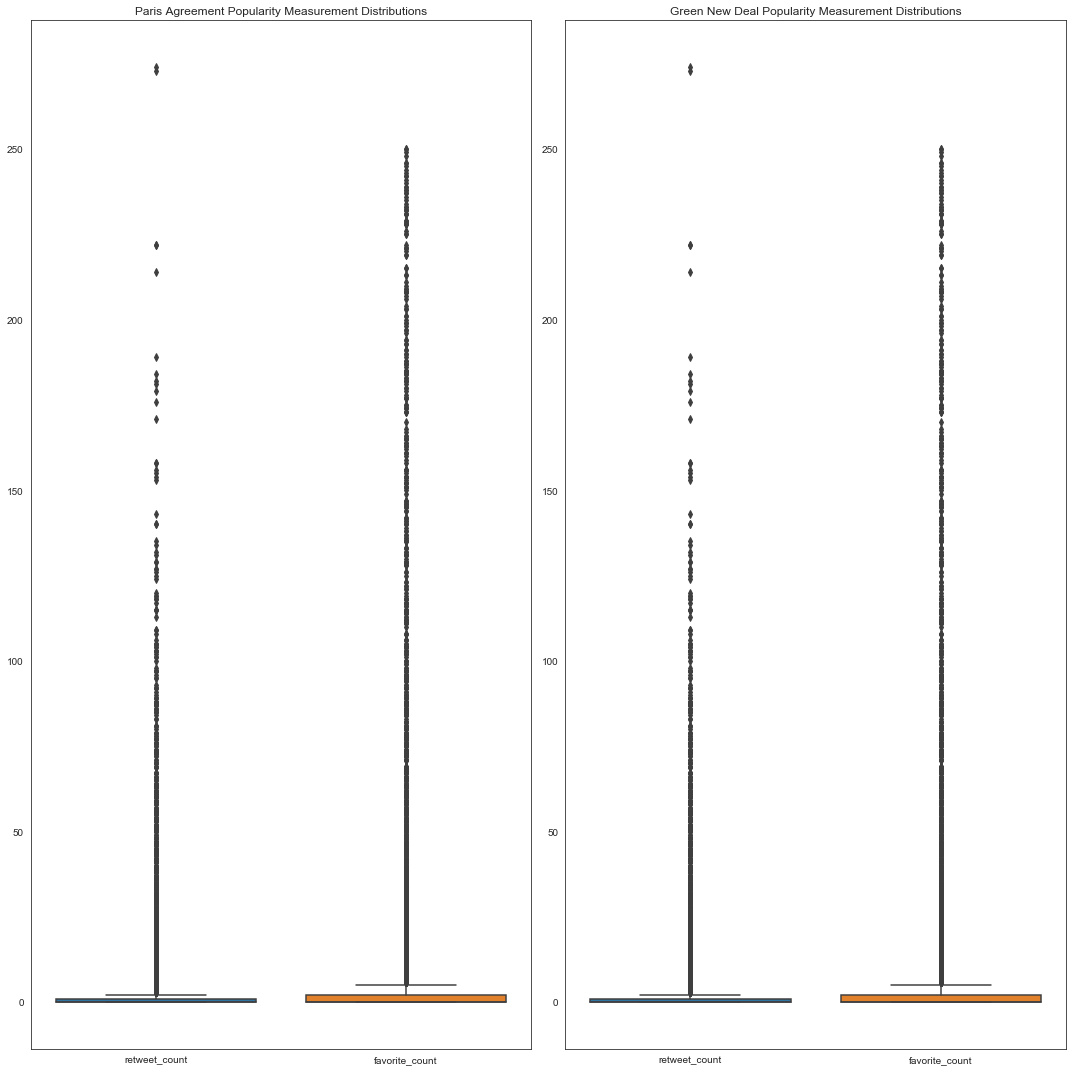

In [14]:
fig,ax = plt.subplots(1,2, figsize = (15,15))
sns.boxplot(data = paris_short[["retweet_count", "favorite_count"]], ax = ax[0])
ax[0].set_title("Paris Agreement Popularity Measurement Distributions")
sns.boxplot(data = paris_short[["retweet_count", "favorite_count"]], ax = ax[1])
ax[1].set_title("Green New Deal Popularity Measurement Distributions")
plt.tight_layout()
plt.show()

##### Let's look at the emotional profiles for tweets with over 1000 likes

Text(0.5, 1.0, 'Emotions, Popular Paris Agreement Tweets')

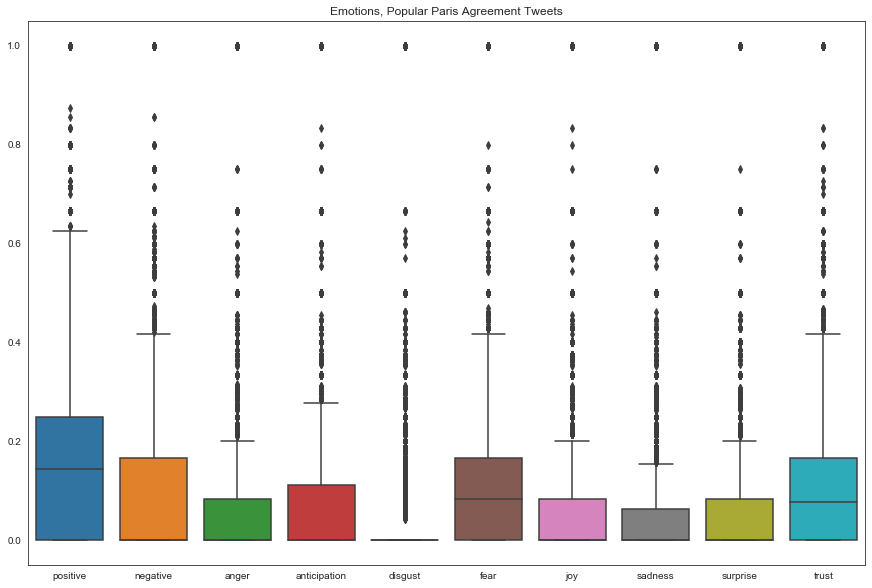

In [15]:
fig,ax = plt.subplots(figsize = (15,10))
sns.boxplot(data = paris[emotions], ax = ax)
ax.set_title("Emotions, Popular Paris Agreement Tweets")

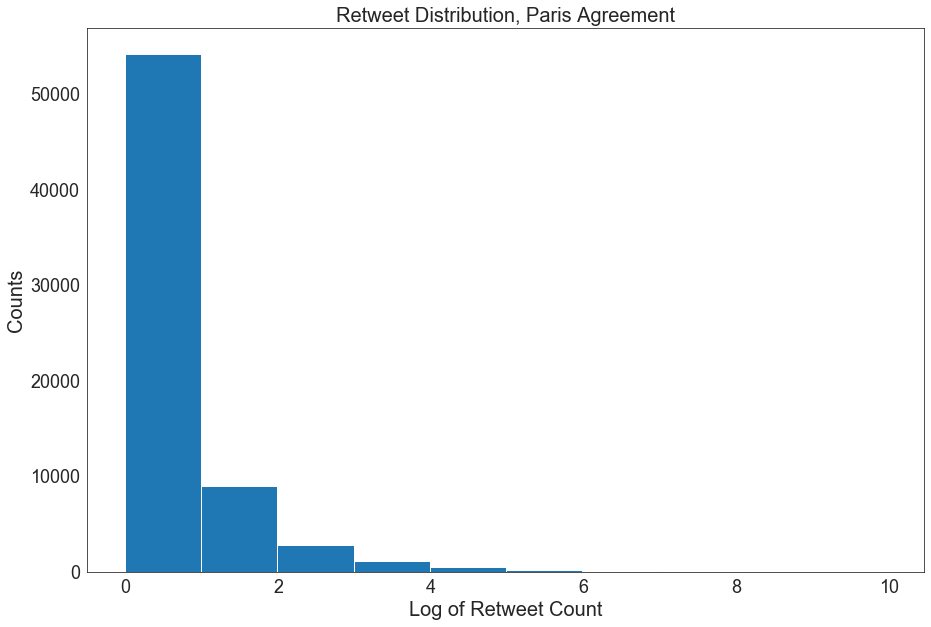

In [16]:
fig,ax = plt.subplots(figsize = (15,10))
ax.hist(np.log(paris["retweet_count"]+1))
ax.set_title("Retweet Distribution, Paris Agreement", fontsize = 20)
ax.set_xlabel("Log of Retweet Count", fontsize = 20)
ax.set_ylabel("Counts", fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
plt.show()

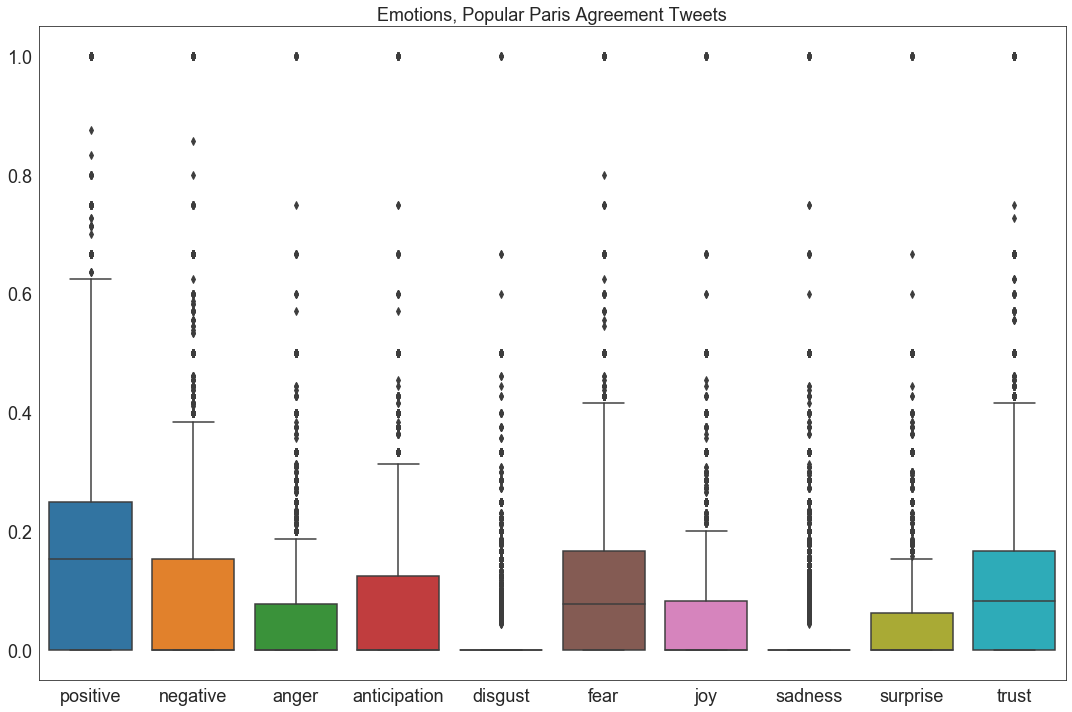

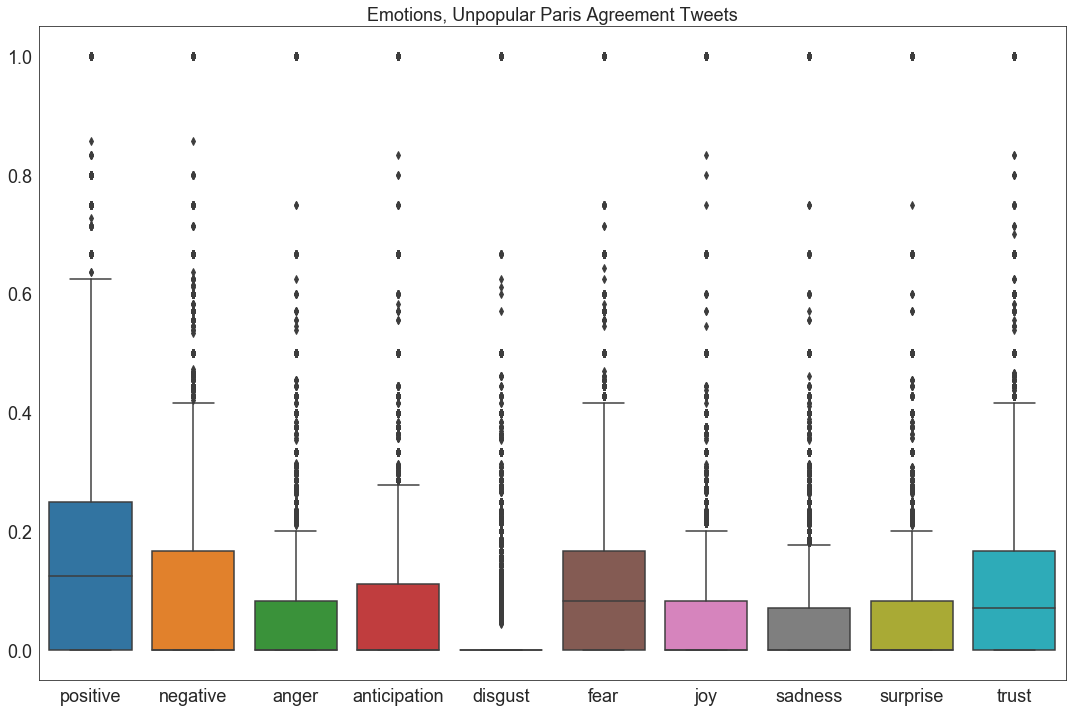

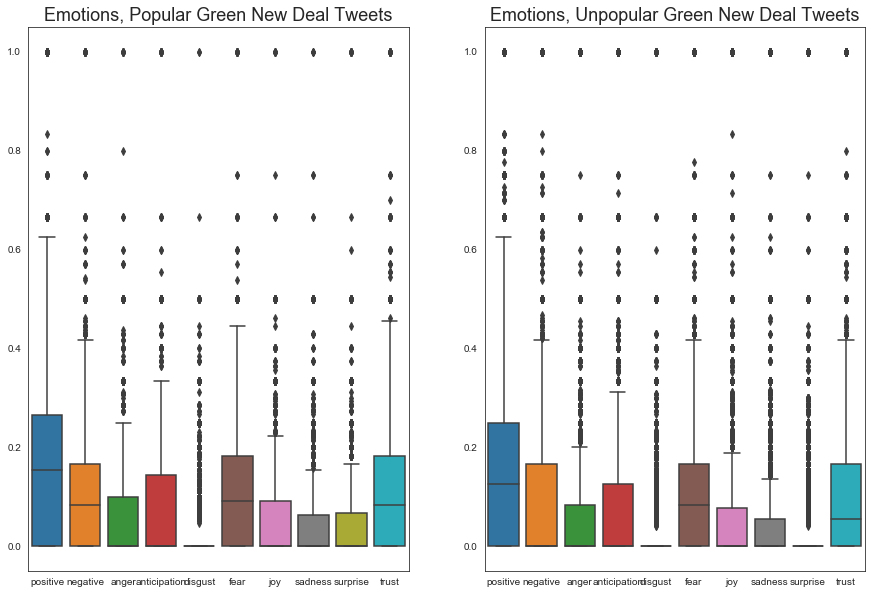

In [29]:
#### pop_paris = paris[paris["retweet_count"] > 1]
unpop_paris = paris[paris["retweet_count"] <= 1]
pop_gnd = gnd[gnd["retweet_count"] > 1]
unpop_gnd = gnd[gnd["retweet_count"] <= 1]
pop_paris = paris[paris["retweet_count"] > 1]

fig,ax = plt.subplots(figsize = (15,10))
# df_long = pd.melt(df, "b", var_name="a", value_name="c")
sns.boxplot(data = pop_paris[emotions], ax = ax)
ax.set_title("Emotions, Popular Paris Agreement Tweets", fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
plt.tight_layout()
plt.show()

fig,ax = plt.subplots(figsize = (15,10))
sns.boxplot(data = unpop_paris[emotions], ax = ax)
ax.set_title("Emotions, Unpopular Paris Agreement Tweets", fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
plt.tight_layout()
plt.show()

fig,ax = plt.subplots(1,2, figsize = (15,10))
sns.boxplot(data = pop_gnd[emotions], ax = ax[0])
ax[0].set_title("Emotions, Popular Green New Deal Tweets", fontsize = 18)
sns.boxplot(data = unpop_gnd[emotions], ax = ax[1])
ax[1].set_title("Emotions, Unpopular Green New Deal Tweets", fontsize = 18)
plt.show()

In [28]:
# fig,ax = plt.subplots(figsize = (15,10))
# pop_paris_emotions = pop_paris[emotions].mean(axis = 0, skipna = True).rename_axis("emotions").reset_index(name="avg_emotion").sort_values(by = "avg_emotion")[::-1]
# unpop_paris_emotions = unpop_paris[emotions].mean(axis = 0, skipna = True).rename_axis("emotions").reset_index(name="avg_emotion").sort_values(by = "avg_emotion")[::-1]
# pop_paris_emotions["Popularity"] = "Popular"
# unpop_paris_emotions["Popularity"] = "Unpopular"
# df_all = pd.concat([pop_paris_emotions, unpop_paris_emotions], axis = 0)
# df_all.info()

# df_long = pd.melt(df_all, "Popularity", var_name="emotions", value_name="avg_emotions")

# # df_long = pd.melt(df, "b", var_name="a", value_name="c")
# df_long.head()
# # sns.boxplot(x="a", hue="b", y="c", data=df_long)

# # df_all.head()
# sns.boxplot(x="emotions", hue="Popularity", y="avg_emotions", data=df_all)

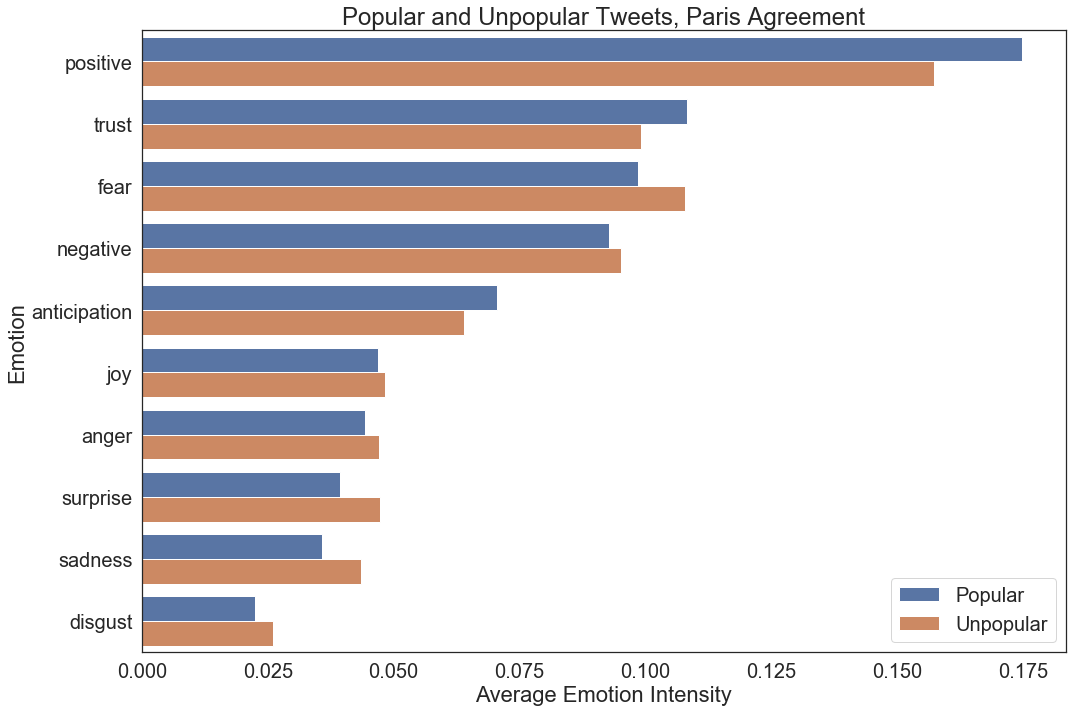

In [70]:
# import matplotlib
# matplotlib.rc('font', size= 'LARGE_SIZE')

fig,ax = plt.subplots(figsize = (15,10))
pop_paris_emotions = pop_paris[emotions].mean(axis = 0, skipna = True).rename_axis("emotions").reset_index(name="avg_emotion").sort_values(by = "avg_emotion")[::-1]
unpop_paris_emotions = unpop_paris[emotions].mean(axis = 0, skipna = True).rename_axis("emotions").reset_index(name="avg_emotion").sort_values(by = "avg_emotion")[::-1]
pop_paris_emotions["Popularity"] = "Popular"
unpop_paris_emotions["Popularity"] = "Unpopular"
df_all = pd.concat([pop_paris_emotions, unpop_paris_emotions], axis = 0)

sns.barplot(x="avg_emotion", y="emotions", hue = "Popularity", orient = "h" ,data=df_all, ax = ax)
ax.set_ylabel("Emotion", fontsize = 22)
ax.set_xlabel("Average Emotion Intensity", fontsize = 22)
ax.set_title("Popular and Unpopular Tweets, Paris Agreement", fontsize = 24)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()

In [77]:
pd.DataFrame(paris["retweet_count"].describe())

,retweet_count
count,67866.000000
mean,4.539475
std,122.886597
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,21083.000000


In [80]:
print(len(pop_paris))

13647


In [78]:
pd.DataFrame(gnd["retweet_count"].describe())

,retweet_count
count,27288.000000
mean,10.222809
std,308.806709
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,47852.000000


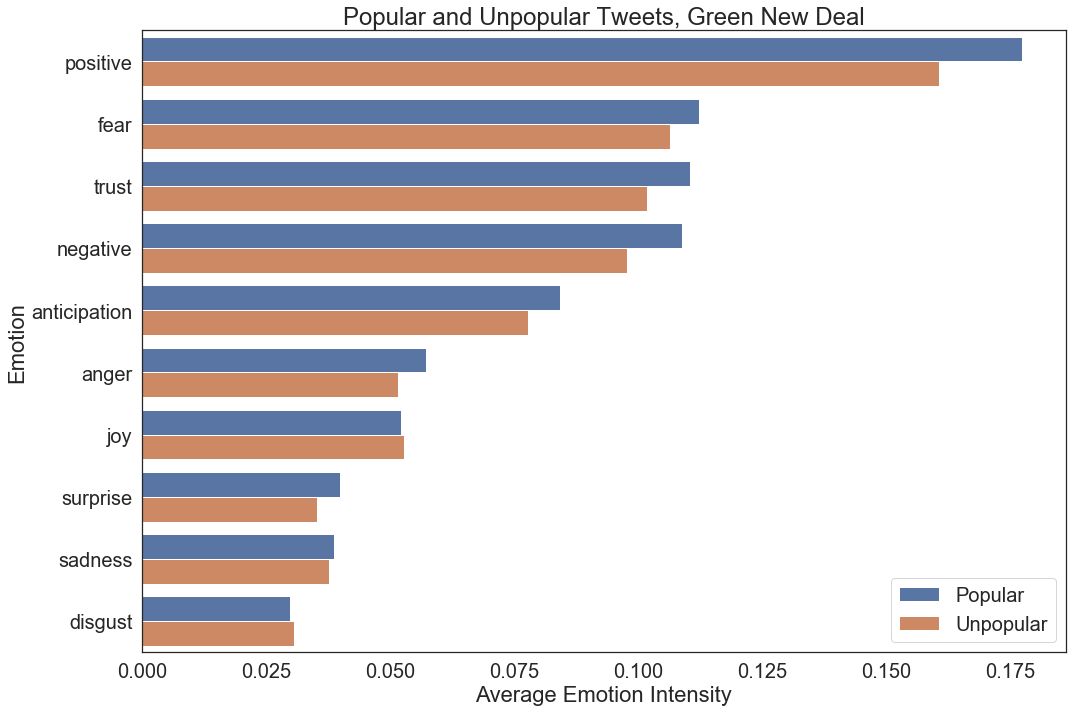

In [71]:
fig,ax = plt.subplots(figsize = (15,10))
pop_gnd_emotions = pop_gnd[emotions].mean(axis = 0, skipna = True).rename_axis("emotions").reset_index(name="avg_emotion").sort_values(by = "avg_emotion")[::-1]
unpop_gnd_emotions = unpop_gnd[emotions].mean(axis = 0, skipna = True).rename_axis("emotions").reset_index(name="avg_emotion").sort_values(by = "avg_emotion")[::-1]
pop_gnd_emotions["Popularity"] = "Popular"
unpop_gnd_emotions["Popularity"] = "Unpopular"
df_all = pd.concat([pop_gnd_emotions, unpop_gnd_emotions], axis = 0)

sns.barplot(x="avg_emotion", y="emotions", hue = "Popularity", orient = "h" ,data=df_all, ax = ax)
ax.set_ylabel("Emotion", fontsize = 22)
ax.set_xlabel("Average Emotion Intensity", fontsize = 22)
ax.set_title("Popular and Unpopular Tweets, Green New Deal", fontsize = 24)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()

In [23]:
ttests_emotions = []
for emotion in emotions:
    df = pingouin.ttest(pop_paris[emotion], unpop_paris[emotion])
    df["emotion"] = emotion
    df["average_intensity_popular"] = pop_paris[emotion].mean()
    df["average_intensity_unpopular"] = unpop_paris[emotion].mean() 
    ttests_emotions.append(df)
ttests_emotions = pd.concat(ttests_emotions).set_index("emotion")
print("Popular versus unpopular tweets, different in emotions, Paris Agreement")
display(ttests_emotions)

Popular versus unpopular tweets, different in emotions, Paris Agreement


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power,average_intensity_popular,average_intensity_unpopular
emotion,,,,,,,,,,
positive,10.856297,21334.329236,two-sided,2.195223e-27,"[0.01, 0.02]",0.102845,3.939e+23,1.000000,0.174758,0.157405
negative,-1.737940,21258.765840,two-sided,8.223592e-02,"[-0.0, 0.0]",0.016510,0.049,0.406809,0.092882,0.095132
anger,-3.177614,22082.019889,two-sided,1.486970e-03,"[-0.0, -0.0]",0.029323,1.68,0.864719,0.044410,0.047137
anticipation,6.234739,21701.498786,two-sided,4.608769e-10,"[0.0, 0.01]",0.058289,2.946e+06,1.000000,0.070496,0.063913
disgust,-5.617929,23584.884000,two-sided,1.954388e-08,"[-0.0, -0.0]",0.049508,7.64e+04,0.999335,0.022522,0.026040
fear,-7.947860,21897.497225,two-sided,1.988720e-15,"[-0.01, -0.01]",0.073802,5.487e+11,1.000000,0.098571,0.107903
joy,-1.582868,21713.508652,two-sided,1.134662e-01,"[-0.0, 0.0]",0.014792,0.038,0.339135,0.046848,0.048249
sadness,-9.297338,22321.527167,two-sided,1.568435e-20,"[-0.01, -0.01]",0.085120,6.102e+16,1.000000,0.035760,0.043426
surprise,-9.712906,23270.320888,two-sided,2.928230e-22,"[-0.01, -0.01]",0.086369,3.148e+18,1.000000,0.039263,0.047251


In [24]:
ttests_emotions = []
for emotion in emotions:
    df = pingouin.ttest(pop_gnd[emotion], unpop_gnd[emotion])
    df["emotion"] = emotion
    df["average_intensity_popular"] = pop_gnd[emotion].mean()
    df["average_intensity_unpopular"] = unpop_gnd[emotion].mean() 
    ttests_emotions.append(df)
ttests_emotions = pd.concat(ttests_emotions).set_index("emotion")
print("Popular versus unpopular tweets, different in emotions, Green New Deal")
display(ttests_emotions)

Popular versus unpopular tweets, different in emotions, Green New Deal


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power,average_intensity_popular,average_intensity_unpopular
emotion,,,,,,,,,,
positive,7.417516,9313.687397,two-sided,1.297760e-13,"[0.01, 0.03]",0.110064,1.465e+10,1.000000,0.177298,0.157472
negative,5.139972,9031.213558,two-sided,2.805327e-07,"[0.01, 0.02]",0.077770,9365.031,0.998866,0.108756,0.097701
anger,3.734000,9028.155704,two-sided,1.896215e-04,"[0.0, 0.01]",0.056509,18.493,0.953747,0.057325,0.051468
anticipation,3.990159,9618.648071,two-sided,6.651893e-05,"[0.0, 0.01]",0.058064,49.66,0.962670,0.084191,0.076546
disgust,-0.970511,9443.210480,two-sided,3.318169e-01,"[-0.0, 0.0]",0.014279,0.028,0.151252,0.029923,0.031020
fear,2.652150,8872.941443,two-sided,8.012326e-03,"[0.0, 0.01]",0.040596,0.587,0.744298,0.112215,0.106980
joy,0.371437,9744.029374,two-sided,7.103204e-01,"[-0.0, 0.0]",0.005364,0.019,0.063804,0.052272,0.051695
sadness,0.643671,9136.366886,two-sided,5.198048e-01,"[-0.0, 0.0]",0.009667,0.022,0.095527,0.038672,0.037826
surprise,3.786026,8696.609480,two-sided,1.541054e-04,"[0.0, 0.01]",0.058743,22.482,0.966097,0.039984,0.034737


#### Linear Regression Analysis

In [20]:
# fig,ax = plt.subplots(5,2, figsize = (15,15))
# row = 0
# col = 0
# for emotion in emotions:
#     ax[row][col].scatter(paris[emotion], paris["retweet_count"])
#     ax[row][col].set_title(str(emotion) + " vs. reweet count")
#     if col < 1:
#         col += 1
#     else:
#         col = 0
#         row += 1
# plt.tight_layout()
# plt.show()

In [29]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [42]:
len(pop_paris)

62

In [50]:
param_grid = [{'regressor': [Ridge()],
               'regressor__alpha': [0.1,1,10,100]},
              {'regressor': [Lasso()],
               'regressor__alpha': [0.1,1,10,100]},
              {'regressor': [ElasticNet()],
               'regressor__alpha': [0.1,1,10,100],'regressor__l1_ratio':[0.25,0.5,0.75]}]

In [51]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('regressor', Ridge())])

In [52]:
grid = GridSearchCV(pipe, param_grid)
paris_pop = grid.fit(pop_paris[emotions],pop_paris[["retweet_count", "favorite_count"]])

In [58]:
print(len(pop_paris))
print(len(paris))

62
67866


In [53]:
print(paris_pop.best_estimator_)
print(paris_pop.best_score_)
print(paris_pop.best_estimator_.named_steps["regressor"].coef_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', ElasticNet(alpha=100, l1_ratio=0.25))])
-1.0568611139022424
[[ -2.76345513  -0.           4.66719611  -3.66128464   0.34044233
    4.12126693  -1.41379464  -0.88321166  -4.08148729   7.51369259]
 [ -2.10936695  -1.81022473  15.36705356  -6.45226907  -0.
   17.98891531  -1.16327348  -6.21220681 -12.12389639  25.65077032]]


In [54]:
paris_all = grid.fit(paris[emotions], paris[["retweet_count", "favorite_count"]])

In [55]:
print(paris_all.best_estimator_)
print(paris_all.best_score_)
print(paris_all.best_estimator_.named_steps["regressor"].coef_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', ElasticNet(alpha=10, l1_ratio=0.25))])
-0.0009964322055281637
[[ 0.  0.  0. -0. -0.  0. -0. -0. -0.  0.]
 [ 0. -0.  0. -0. -0.  0. -0. -0. -0.  0.]]


In [65]:
paris_all_rev = grid.fit(paris[["retweet_count", "favorite_count"]], paris[emotions])

In [66]:
print(paris_all_rev.best_estimator_)
print(paris_all_rev.best_score_)
print(paris_all_rev.best_estimator_.named_steps["regressor"].coef_)

Pipeline(steps=[('scaler', StandardScaler()), ('regressor', Lasso(alpha=0.1))])
-0.005131996605680698
[[ 0.  0.]
 [ 0. -0.]
 [ 0.  0.]
 [-0. -0.]
 [-0. -0.]
 [ 0.  0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [ 0.  0.]]


In [67]:
paris_pop_rev = grid.fit(pop_paris[["retweet_count", "favorite_count"]], pop_paris[emotions])

In [68]:
print(paris_pop_rev.best_estimator_)
print(paris_pop_rev.best_score_)
print(paris_pop_rev.best_estimator_.named_steps["regressor"].coef_)

Pipeline(steps=[('scaler', StandardScaler()), ('regressor', Lasso(alpha=0.1))])
-0.17401252277112678
[[-0. -0.]
 [-0. -0.]
 [ 0.  0.]
 [-0. -0.]
 [ 0. -0.]
 [ 0.  0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [ 0.  0.]]


#### Time Series Analysis

In [39]:
# import matplotlib
# matplotlib.use('agg')
# from fbprophet.plot import plot_plotly, plot_components_plotly
# from fbprophet import Prophet
# from fbprophet.plot import add_changepoints_to_plot

In [8]:
# paris["created_at"] = pd.to_datetime(paris["created_at"])
# gnd["created_at"] = pd.to_datetime(gnd["created_at"])
# paris["ds"] = paris["created_at"].dt.date
# gnd["ds"] = gnd["created_at"].dt.date
# paris["y"] = (paris["positive"] - paris["negative"])/2
# gnd["y"] = (gnd["positive"] - gnd["negative"])/2

In [40]:
# paris_prophet = Prophet()
# gnd_prophet = Prophet()
# paris_prophet.fit(paris)
# gnd_prophet.fit(gnd)

In [41]:
# fig = paris_prophet.plot(paris)
# a = add_changepoints_to_plot(fig.gca(), paris_prophet, paris)

In [42]:
# fig = gnd_prophet.plot(gnd)
# a = add_changepoints_to_plot(fig.gca(), gnd_prophet, gnd)